In [31]:
from dotenv import load_dotenv
load_dotenv()

True

In [32]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("google_genai:gemini-2.0-flash")

In [33]:
# State define
from typing import TypedDict, Annotated
from langgraph.graph import add_messages

class ChatState(TypedDict):
    messages: Annotated[list, add_messages]

In [34]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

In [35]:
@tool
def get_price(symbol: str) -> float:
    # required docstring -> needed for langchain to identify the tool
    """Return the stock price for the given symbol."""
    return {
        "MSFT": 200.3,
        "AAPL": 100.4,
        "AMZN": 150.0,
        "RIL": 87.6
    }.get(symbol, 0.0)

tools = [get_price]
llm_with_tools = llm.bind_tools(tools)

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


In [36]:
tools

[StructuredTool(name='get_price', description='Return the stock price for the given symbol.', args_schema=<class 'langchain_core.utils.pydantic.get_price'>, func=<function get_price at 0x0000029DCD60A480>)]

In [37]:
def chatbot(state: ChatState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [38]:
# graph with tool
from langgraph.graph import StateGraph, START, END
builder = StateGraph(ChatState)
builder.add_node("chat_node", chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chat_node")
builder.add_conditional_edges("chat_node", tools_condition)

graph = builder.compile()

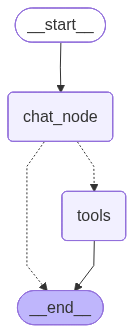

In [39]:
# Visualising the graph
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [40]:
graph.invoke({'messages': ["Who is the father of computer?"]})

{'messages': [HumanMessage(content='Who is the father of computer?', additional_kwargs={}, response_metadata={}, id='3b5a8460-0cb9-49f2-a5f3-6c1994957136'),
  AIMessage(content='Charles Babbage is widely considered the "father of the computer."\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--721c60b6-db82-437f-b740-9491d2881fad-0', usage_metadata={'input_tokens': 32, 'output_tokens': 14, 'total_tokens': 46})]}

In [41]:
graph.invoke({'messages': ["What is the price of AAPL stock right now?"]})

{'messages': [HumanMessage(content='What is the price of AAPL stock right now?', additional_kwargs={}, response_metadata={}, id='e5dfcc6e-3ea9-431f-89f7-952475f4eaff'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_price', 'arguments': '{"symbol": "AAPL"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--1ceb3245-a420-4caa-9839-80b3e92881b7-0', tool_calls=[{'name': 'get_price', 'args': {'symbol': 'AAPL'}, 'id': 'ccff63eb-5b3c-41f3-a2ba-90edd47de475', 'type': 'tool_call'}], usage_metadata={'input_tokens': 36, 'output_tokens': 6, 'total_tokens': 42}),
  ToolMessage(content='100.4', name='get_price', id='10c778cf-2eb6-496e-894b-6356823b719d', tool_call_id='ccff63eb-5b3c-41f3-a2ba-90edd47de475')]}

In [43]:
res = graph.invoke({'messages': ['I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?']})
res

{'messages': [HumanMessage(content='I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?', additional_kwargs={}, response_metadata={}, id='f830cf9c-8a7c-4024-b03e-60a17953bf87'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_price', 'arguments': '{"symbol": "MSFT"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--ce570b25-70de-4e9c-95bb-96e1f8cab9f6-0', tool_calls=[{'name': 'get_price', 'args': {'symbol': 'AMZN'}, 'id': '1450271c-8464-4fff-b62b-2c952c23f9e2', 'type': 'tool_call'}, {'name': 'get_price', 'args': {'symbol': 'MSFT'}, 'id': 'a9e11ba3-f468-4d37-a117-ac6881c052bf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 53, 'output_tokens': 12, 'total_tokens': 65}),
  ToolMessage(content='150.0', name='get_price', id='f9e241ef-f6e9-4f95-a100-599c70911c0a', tool_call_id='1450271c-8464-4fff-b62b-2c952c23f9e2'),
  ToolMes

In [ ]:
res['messages'][-1].content # flaw of this graph structure

'200.3'